In [1]:
from neural_analysis_pkg.core import NeuralAnalysis
import os 

In [ ]:
# Define the path to your project folder
project_folder_path ='/home/cresp1el-local/Documents/MATLAB/Data/lmc_project_v2/LED'
# Initialize the NeuralAnalysis class with the project folder path
analysis = NeuralAnalysis(project_folder_path)

#uncomment if required
# analysis.process_dat_file(project_folder_path) #process dat file

In [ ]:
analysis.recording_results_df #show recording results dataframe

In [ ]:
analysis.process_MUA() #process MUA

In [ ]:
# save this dataframe to a csv file using the csv file path as the argument so you dont have to run the downsampling and filtering again
# analysis.recording_results_df.to_csv(os.path.join(project_folder_path,'SpikeStuff/recording_results.csv'))

In [ ]:
analysis.extract_stimulation_data() 

In [ ]:
analysis.stimulation_data_df #show stimulation data dataframe

In [ ]:
analysis.extract_spike_times() #detect spikes from MUA data using thresholding method

In [ ]:
analysis.recording_results_df


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def calculate_firing_rates(recording_name, recording_results_df, stimulation_data_df, n_channels):
    # Get the mua_data_path for the current recording to get the spike_data_path where the spike times are stored
    mua_data_path = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'mua_data_path'
    ].values[0]
    
    # Construct the spike_data_path from the mua_data_path
    spike_data_path = mua_data_path.replace('_MUA.npy', '_spike_times.npy')
    
    # Step 1: Identify the time windows for stimulus_id = 8, which is an 8Hz signal 
    stim_data = stimulation_data_df[
        (stimulation_data_df['recording_name'] == recording_name) & 
        (stimulation_data_df['stimulation_ids'] == 8)
    ]
    
    # Step 2: Load the corresponding spike times
    spike_data = np.load(spike_data_path, allow_pickle=True)
    spike_times = spike_data['time']
    spike_channels = spike_data['channel']
    
    # Get good and noisy channels for the current recording
    good_channels = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'good_channels'
    ].values[0]
    noisy_channels = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'noisy_channels'
    ].values[0]

    # Step 3 & 4: Calculate and aggregate the firing rates
    firing_rates = np.full((n_channels, len(stim_data)), np.nan) # Initialize with NaNs 

    for i, (onset, offset) in enumerate(zip(stim_data['onset_times'], stim_data['offset_times'])):
        for ch in good_channels:
            # Find spikes in the current channel and time window
            condition = (spike_channels == ch) & (spike_times >= onset) & (spike_times <= offset)
            spikes_in_window = spike_times[np.where(condition)]
            
            # Calculate the firing rate
            firing_rate = len(spikes_in_window) / (offset - onset)
            firing_rates[ch, i] = firing_rate
    
    # Step 5: Plotting the heatmap
    plt.imshow(firing_rates, aspect='auto', cmap='hot', interpolation='nearest')
    plt.colorbar(label='Firing Rate (Hz)')
    plt.ylabel('Channel')
    plt.xlabel('Trial')
    plt.title('Firing Rate Heatmap for Stimulus ID = 8 Hz LED')
    plt.yticks(range(n_channels), range(1, n_channels+1))  # Label y-axis with channel numbers
    plt.show()
    
calculate_firing_rates('lmc_ch_2_3093_rec1', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels)

In [ ]:
calculate_firing_rates('lmc_ch_1_3094_rec1', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels)

In [ ]:
calculate_firing_rates('lmc_ch_1_3094_rec2', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels)

In [ ]:
calculate_firing_rates('lmc_noch_1_3096_rec1', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels)

In [ ]:
calculate_firing_rates('lmc_noch_1_3096_rec2', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels)

In [6]:
from scipy.ndimage import gaussian_filter1d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def estimate_instantaneous_firing_rate(recording_name, recording_results_df, n_channels, bin_size=0.001, window_length=0.05, window_sd=0.005):
    """
    Estimate the instantaneous firing rate by convolving the spike time series with a Gaussian window.

    Parameters:
    - recording_name (str): The name of the recording to process.
    - recording_results_df (pd.DataFrame): The data frame containing the recording results.
    - n_channels (int): The number of channels in the recording.
    - bin_size (float): The bin size for discretizing the spike times, in seconds. Default is 1 ms (0.001 s).
    - window_length (float): The length of the Gaussian window in seconds. Default is 50 ms (0.05 s).
    - window_sd (float): The standard deviation of the Gaussian window in seconds. Default is 5 ms (0.005 s).
    
    Returns:
    - firing_rate_estimates (ndarray): A 2D array where each row represents a channel and each column represents a time bin. The values represent the estimated firing rates in Hz.
    """

    # Get the mua_data_path for the current recording to get the spike_data_path where the spike times are stored
    mua_data_path = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'mua_data_path'
    ].values[0]
    
    # Construct the spike_data_path from the mua_data_path
    spike_data_path = mua_data_path.replace('_MUA.npy', '_spike_times.npy')
    
    # Step 1: Load the spike data
    spike_data = np.load(spike_data_path, allow_pickle=True)
    spike_times = spike_data['time']
    spike_channels = spike_data['channel']

    # Step 2: Determine the duration from the MUA data
    mua_data = np.load(mua_data_path)
    duration = mua_data.shape[0] / 10000  # Convert number of samples to seconds (assuming 10 kHz sampling rate)

    # Step 3: Create a time vector with bins
    time_vector = np.arange(0, duration, bin_size)

    # Step 4: Create a spike train matrix with each row representing a channel and each column representing a time bin
    spike_trains = np.zeros((n_channels, len(time_vector) - 1))

    for ch in range(n_channels):
        spike_times_ch = spike_times[spike_channels == ch]
        spike_trains[ch, :] = np.histogram(spike_times_ch, bins=time_vector)[0]

    # Step 5: Convolve the spike train with a Gaussian window to estimate the instantaneous firing rate
    window_length_bins = int(window_length / bin_size)  # Convert window length from seconds to number of bins
    window_sd_bins = window_sd / bin_size  # Convert window SD from seconds to number of bins
    firing_rate_estimates = np.zeros_like(spike_trains)

    for ch in range(n_channels):
        firing_rate_estimates[ch, :] = gaussian_filter1d(spike_trains[ch, :], sigma=window_sd_bins)

    return firing_rate_estimates

#run the function
#firing_rate_estimates = estimate_instantaneous_firing_rate('lmc_ch_2_3093_rec1', analysis.recording_results_df, analysis.n_channels)

In [ ]:
# Plot the heatmap
plt.imshow(firing_rate_estimates, aspect='auto', cmap='hot', interpolation='nearest', extent=[0, firing_rate_estimates.shape[1], 0, firing_rate_estimates.shape[0]])
plt.colorbar(label='Firing Rate (Hz)')
plt.ylabel('Channel')
plt.xlabel('Time (bins)')
plt.title('Instantaneous Firing Rate')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_psth(recording_name, recording_results_df, stimulation_data_df, n_channels, firing_rate_estimates, stim_id, bin_size=0.001):
    
    # Get the mua_data_path for the current recording to get the spike_data_path where the spike times are stored
    mua_data_path = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'mua_data_path'
    ].values[0]
    
    # Construct the spike_data_path from the mua_data_path
    spike_data_path = mua_data_path.replace('_MUA.npy', '_spike_times.npy')
    
    # Step 1: Identify the time windows for the specified stimulus_id
    stim_data = stimulation_data_df[
        (stimulation_data_df['recording_name'] == recording_name) & 
        (stimulation_data_df['stimulation_ids'] == stim_id)
    ]
    
    # Get good and noisy channels for the current recording
    good_channels = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'good_channels'
    ].values[0]

    # Find the minimum onset and maximum offset times to get a common time window for all trials
    min_onset = stim_data['onset_times'].min() - 0.5  # 500 ms before the minimum onset
    max_offset = stim_data['offset_times'].max() + 0.5  # 500 ms after the maximum offset

    # Find the bins corresponding to the common time window
    start_bin = int(min_onset / bin_size)
    end_bin = int(max_offset / bin_size)

    # Initialize arrays to accumulate the sums and counts for each bin
    sum_psth = np.zeros((n_channels, end_bin - start_bin))
    count_psth = np.zeros((n_channels, end_bin - start_bin))

    # Loop through each trial to calculate the PSTH
    for i, (onset, offset) in enumerate(zip(stim_data['onset_times'], stim_data['offset_times'])):
        # Find the bins corresponding to the current time window
        trial_start_bin = int((onset - 0.5) / bin_size)
        trial_end_bin = int((offset + 0.5) / bin_size)

        # Add the firing rate estimates to the sum and update the count in the relevant bins
        sum_psth[:, trial_start_bin - start_bin : trial_end_bin - start_bin] += firing_rate_estimates[:, trial_start_bin:trial_end_bin]
        count_psth[:, trial_start_bin - start_bin : trial_end_bin - start_bin] += 1
    
    # Calculate the mean PSTH by dividing the sum by the count
    mean_psth = np.divide(sum_psth, count_psth, where=(count_psth!=0))

    # Plotting the mean PSTH for each channel
    time_bins = np.linspace(min_onset, max_offset, end_bin - start_bin)
    plt.figure()
    for ch in good_channels:
        plt.plot(time_bins, mean_psth[ch, :])
    
    plt.xlabel('Time (s)')
    plt.ylabel('Firing Rate (Hz)')
    plt.title(f'Mean PSTH for Stimulus ID = {stim_id}')
    plt.show()

#first get the firing rate estimates for the recording name
firing_rate_estimates = estimate_instantaneous_firing_rate('lmc_ch_2_3093_rec1', analysis.recording_results_df, analysis.n_channels)
#run the function 
calculate_psth('lmc_ch_2_3093_rec1', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels, firing_rate_estimates, stim_id=8, bin_size=0.001)

In [ ]:
def calculate_psth(recording_name, recording_results_df, stimulation_data_df, n_channels, firing_rate_estimates, stim_id=1, bin_size=0.001):
    # Get the mua_data_path for the current recording
    mua_data_path = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'mua_data_path'
    ].values[0]
    
    # Step 1: Identify the time windows for the specified stimulus_id
    stim_data = stimulation_data_df[
        (stimulation_data_df['recording_name'] == recording_name) & 
        (stimulation_data_df['stimulation_ids'] == stim_id)
    ]
    
    # Get good and noisy channels for the current recording
    good_channels = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'good_channels'
    ].values[0]
    noisy_channels = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'noisy_channels'
    ].values[0]

    # Exclude noisy channels from good channels
    good_channels = [ch for ch in good_channels if ch not in noisy_channels]

    # Step 2 & 3: Aggregate the PSTH data
    psth_duration_in_s = 1.5  # PSTH duration in seconds (1500 ms)
    num_bins = int(psth_duration_in_s / bin_size)
    sum_psth = np.zeros((n_channels, num_bins))  # Initialize with zeros
    count_psth = np.zeros((n_channels, num_bins))  # Initialize with zeros

    for i, (onset, offset) in enumerate(zip(stim_data['onset_times'], stim_data['offset_times'])):
        for ch in good_channels:
            # Find the bins corresponding to the current time window (from -500ms to +1000ms relative to the onset)
            start_bin = int((onset - 0.5) / bin_size)
            end_bin = int((onset + 1.0) / bin_size)
            
            # within your loop where you extract trial_psth
            trial_psth = firing_rate_estimates[ch, start_bin:end_bin][:1500]
            
            #accumulate the sum and update the count in the relevant bins
            try: 
                sum_psth[ch, :] += np.nan_to_num(trial_psth)
                count_psth[ch, :] += np.isfinite(trial_psth)
            except ValueError: 
                # If lengths are mismatched, extend trial_psth with its last value
                if len(trial_psth) == len(sum_psth[ch, :]) - 1:
                    trial_psth = np.append(trial_psth, trial_psth[-1])
                    sum_psth[ch, :] += np.nan_to_num(trial_psth)
                    count_psth[ch, :] += np.isfinite(trial_psth)
                else:
                    print("Unexpected mismatch in lengths")
 
    # Calculate the mean PSTH by dividing the sum by the count
    mean_psth = np.divide(sum_psth, count_psth, where=(count_psth!=0))
    
    # Convert firing rate from spikes per bin to spikes per second (Hz)
    mean_psth /= bin_size

    # Create a time axis that spans from -500 ms to +1000 ms
    time_axis = np.linspace(-500, 1000, num_bins)

    # Step 4: Plotting the mean PSTH for each channel
    plt.figure()
    for ch in range(n_channels):
        plt.plot(time_axis, mean_psth[ch, :])
        plt.xlabel('Time (ms)')
        plt.ylabel('Firing Rate (Hz)')
        plt.title(f'Channel {ch+1}')
        plt.axvline(x=0, color='r', linestyle='--')  # Mark stimulus onset
        plt.axvline(x=500, color='r', linestyle='--')  # Mark stimulus offset
        plt.show()

#run the function with the firing rate estimates
calculate_psth('lmc_ch_2_3093_rec1', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels, firing_rate_estimates, stim_id=8, bin_size=0.001)

In [ ]:
analysis.recording_results_df['recording_name']

In [ ]:
calculate_psth('lmc_ch_1_3094_rec1', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels, firing_rate_estimates, stim_id=8, bin_size=0.001)

calculate_psth('lmc_ch_1_3094_rec2', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels, firing_rate_estimates, stim_id=8, bin_size=0.001)

In [ ]:
calculate_psth('lmc_ch_1_3094_rec2', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels, firing_rate_estimates, stim_id=8, bin_size=0.001)

In [ ]:
calculate_psth('lmc_noch_1_3096_rec1', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels, firing_rate_estimates, stim_id=8, bin_size=0.001)

In [ ]:
calculate_psth('lmc_noch_1_3096_rec2', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels, firing_rate_estimates, stim_id=8, bin_size=0.001)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def bootstrap_ci(data, n_bootstraps=1000, ci=0.99):
    bootstrapped_means = []
    for i in range(n_bootstraps):
        random_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(random_sample))
    lower = np.percentile(bootstrapped_means, (1-ci)/2 * 100)
    upper = np.percentile(bootstrapped_means, (1+ci)/2 * 100)
    return lower, upper


def calculate_psth_and_responsive_channels(recording_name, recording_results_df, stimulation_data_df, n_channels, firing_rate_estimates, stim_id=8, bin_size=0.001):
    # Initialization
    prestimulus_CI = []
    poststimulus_CI = []
    responsive_channels = []
    
    # Existing data retrieval logic
    mua_data_path = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'mua_data_path'
    ].values[0]
    
    stim_data = stimulation_data_df[
        (stimulation_data_df['recording_name'] == recording_name) & 
        (stimulation_data_df['stimulation_ids'] == stim_id)
    ]
    
    good_channels = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'good_channels'
    ].values[0]
    noisy_channels = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'noisy_channels'
    ].values[0]
    
    good_channels = [ch for ch in good_channels if ch not in noisy_channels]
  
    for ch in good_channels:
        all_prestim_data = []
        all_poststim_data = []
        
        for i, (onset, offset) in enumerate(zip(stim_data['onset_times'], stim_data['offset_times'])):
            prestim_start_bin = int((onset - 0.6) / bin_size)
            prestim_end_bin = int(onset / bin_size)
            
            poststim_start_bin = int(onset / bin_size)
            poststim_end_bin = int((onset + 0.1) / bin_size)
            
            # this would be pooling the data from all trials for each channel which each bin is a time point of varying voltage
            # prestim_data = firing_rate_estimates[ch, prestim_start_bin:prestim_end_bin]
            # poststim_data = firing_rate_estimates[ch, poststim_start_bin:poststim_end_bin]
            
            # use the extend method if pooling from all trials for each channel
            # all_prestim_data.extend(prestim_data)
            # all_poststim_data.extend(poststim_data)
            
            prestim_data = np.mean(firing_rate_estimates[ch, prestim_start_bin:prestim_end_bin])
            poststim_data = np.mean(firing_rate_estimates[ch, poststim_start_bin:poststim_end_bin])
            
            all_prestim_data.append(prestim_data)  # Use append here
            all_poststim_data.append(poststim_data)  # Use append here
        
        # Perform bootstrap analysis for 99% CI on the pooled data
        prestim_bootstrap = bootstrap_ci(np.array(all_prestim_data))
        poststim_bootstrap = bootstrap_ci(np.array(all_poststim_data))
        
        # Print for debugging
        print(f"Channel {ch}: Pre-stim CI: {prestim_bootstrap}, Post-stim CI: {poststim_bootstrap}")
        
        prestimulus_CI.append(prestim_bootstrap)
        poststimulus_CI.append(poststim_bootstrap)
        
        if poststim_bootstrap[0] > prestim_bootstrap[1]:
            responsive_channels.append(ch)
    print("Responsive channels:", responsive_channels)

#run the function 
firing_rate_estimates = estimate_instantaneous_firing_rate('lmc_ch_2_3093_rec1', analysis.recording_results_df, analysis.n_channels)
calculate_psth_and_responsive_channels('lmc_ch_2_3093_rec1', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels, firing_rate_estimates, stim_id=8, bin_size=0.001)

THIS IS THE UPDATED CODE...ned to confirm 

In [5]:
def bootstrap_ci(data, n_bootstraps=1000, ci=0.99):
    bootstrapped_means = []
    for i in range(n_bootstraps):
        random_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(random_sample))
    lower = np.percentile(bootstrapped_means, (1-ci)/2 * 100)
    upper = np.percentile(bootstrapped_means, (1+ci)/2 * 100)
    return lower, upper

def calculate_psth_and_responsive_channels(recording_name, recording_results_df, stimulation_data_df, n_channels, firing_rate_estimates, stim_id=8, bin_size=0.001):
    # Initialization
    prestimulus_CI = []
    poststimulus_CI = []
    responsive_channels = []
    
    avg_firing_rates_for_responsive_channels = []
    all_baseline_firing_rates = []
    
    # Existing data retrieval logic
    mua_data_path = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'mua_data_path'
    ].values[0]
    
    stim_data = stimulation_data_df[
        (stimulation_data_df['recording_name'] == recording_name) & 
        (stimulation_data_df['stimulation_ids'] == stim_id)
    ]
    
    good_channels = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'good_channels'
    ].values[0]
    noisy_channels = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'noisy_channels'
    ].values[0]
    
    good_channels = [ch for ch in good_channels if ch not in noisy_channels]
  
    for ch in good_channels:
        all_prestim_data = []
        all_poststim_data = []
        
        for i, (onset, offset) in enumerate(zip(stim_data['onset_times'], stim_data['offset_times'])):
            prestim_start_bin = int((onset - 0.2) / bin_size)
            prestim_end_bin = int(onset / bin_size)
            poststim_start_bin = int(onset / bin_size)
            poststim_end_bin = int((onset + 0.08) / bin_size)
            
            prestim_data = np.mean(firing_rate_estimates[ch, prestim_start_bin:prestim_end_bin]) / bin_size
            poststim_data = np.mean(firing_rate_estimates[ch, poststim_start_bin:poststim_end_bin]) / bin_size
            
            all_prestim_data.append(prestim_data)
            all_poststim_data.append(poststim_data)
        
        prestim_bootstrap = bootstrap_ci(np.array(all_prestim_data))
        poststim_bootstrap = bootstrap_ci(np.array(all_poststim_data))
        
        print(f"Channel {ch}: Pre-stim CI: {prestim_bootstrap}, Post-stim CI: {poststim_bootstrap}")
        
        prestimulus_CI.append(prestim_bootstrap)
        poststimulus_CI.append(poststim_bootstrap)
        
        if poststim_bootstrap[0] > prestim_bootstrap[1]:
            responsive_channels.append(ch)
            avg_firing_rates_for_responsive_channels.append(np.mean(all_poststim_data))
            all_baseline_firing_rates.extend(all_prestim_data)

    print("Responsive channels:", responsive_channels)
    
    single_waveform = np.mean(avg_firing_rates_for_responsive_channels)
    baseline = np.mean(all_baseline_firing_rates)
    percent_change = ((single_waveform - baseline) / baseline) * 100

    print(f"Single LED-evoked waveform: {single_waveform}")
    print(f"Baseline: {baseline}")
    print(f"Percent change relative to baseline: {percent_change}%")


In [ ]:
firing_rate_estimates = estimate_instantaneous_firing_rate('lmc_ch_2_3093_rec1', analysis.recording_results_df, analysis.n_channels)
calculate_psth_and_responsive_channels('lmc_ch_2_3093_rec1', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels, firing_rate_estimates, stim_id=8, bin_size=0.001)

In [ ]:
firing_rate_estimates = estimate_instantaneous_firing_rate('lmc_ch_1_3094_rec1', analysis.recording_results_df, analysis.n_channels)
calculate_psth_and_responsive_channels('lmc_ch_1_3094_rec1', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels, firing_rate_estimates, stim_id=8, bin_size=0.001)

In [ ]:
firing_rate_estimates = estimate_instantaneous_firing_rate('lmc_ch_1_3094_rec2', analysis.recording_results_df, analysis.n_channels)
calculate_psth_and_responsive_channels('lmc_ch_1_3094_rec2', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels, firing_rate_estimates, stim_id=8, bin_size=0.001)

In [ ]:
firing_rate_estimates = estimate_instantaneous_firing_rate('lmc_noch_1_3096_rec1', analysis.recording_results_df, analysis.n_channels)
calculate_psth_and_responsive_channels('lmc_noch_1_3096_rec1', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels, firing_rate_estimates, stim_id=8, bin_size=0.001)

In [ ]:
firing_rate_estimates = estimate_instantaneous_firing_rate('lmc_noch_1_3096_rec2', analysis.recording_results_df, analysis.n_channels)
calculate_psth_and_responsive_channels('lmc_noch_1_3096_rec2', analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels, firing_rate_estimates, stim_id=8, bin_size=0.001)

In [ ]:
analysis.recording_results_df['recording_name']

In [ ]:
analysis.recording_results_df['recording_name'][2]

In [ ]:
analysis.recording_results_df

In [ ]:
def calculate_psth_pre_post(recording_name, recording_results_df, stimulation_data_df, n_channels, firing_rate_estimates, bin_size=0.001, pre_trials=30, post_trials=30):
    # Get good and noisy channels for the current recording
    good_channels = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'good_channels'
    ].values[0]
    noisy_channels = recording_results_df.loc[
        recording_results_df['recording_name'] == recording_name, 
        'noisy_channels'
    ].values[0]

    good_channels = list(set(good_channels) - set(noisy_channels))

    for ch in good_channels:  # Loop through each channel
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # Create a 1x4 subplot for each channel

        for stim_id in range(1, 5):  # Loop through each stimulation ID
            ax = axs[stim_id - 1]  # Get the correct axes

            # Separate the data into pre and post epochs based on the trial range specified
            stim_data = stimulation_data_df[
                (stimulation_data_df['recording_name'] == recording_name) & 
                (stimulation_data_df['stimulation_ids'] == stim_id)
            ]
            stim_data_pre = stim_data.iloc[:pre_trials] # grabs all the rows up to the pre_trials value 
            stim_data_post = stim_data.iloc[-post_trials:] # grabs all the rows from the end of the dataframe to the post_trials value

            # Calculate and plot the mean PSTH for the pre epoch
            mean_psth_pre = calculate_mean_psth(stim_data_pre, firing_rate_estimates, ch, bin_size)
            ax.plot(mean_psth_pre, color='grey', label='Pre')

            # Calculate and plot the mean PSTH for the post epoch
            mean_psth_post = calculate_mean_psth(stim_data_post, firing_rate_estimates, ch, bin_size)
            ax.plot(mean_psth_post, color='blue', label='Post')

            ax.set_title(f'Stim ID = {stim_id}')
            ax.legend()

        plt.tight_layout()
        plt.show()

def calculate_mean_psth(stim_data, firing_rate_estimates, ch, bin_size):
    psth_data = []
    for i, onset in enumerate(stim_data['onset_times']):
        # Define a time window of 1500ms centered on the stimulus onset (500ms pre-stimulus to 1000ms post-stimulus)
        start_bin = int((onset - 0.5) / bin_size)
        end_bin = int((onset + 1.0) / bin_size)
        
        # Get the PSTH data for the current trial
        trial_psth = firing_rate_estimates[ch, start_bin:end_bin]
        psth_data.append(trial_psth)
    
    # Ensuring all trials have the same shape by padding with NaNs to the maximum trial length
    max_len = max(map(len, psth_data))
    psth_data = [np.pad(trial, (0, max_len - len(trial)), 'constant', constant_values=np.nan) for trial in psth_data]

    # Calculate the mean PSTH across trials
    mean_psth = np.nanmean(np.stack(psth_data), axis=0)
        
    # Convert firing rate from spikes per bin to spikes per second (Hz)
    mean_psth /= bin_size
    
    return mean_psth

In [2]:
# Define the path to your project folder
project_folder_path ='/home/cresp1el-local/Documents/MATLAB/Data/lmc_project_v2/Whisker'
# Initialize the NeuralAnalysis class with the project folder path
analysis = NeuralAnalysis(project_folder_path)
analysis.extract_stimulation_data() 


Loaded existing recording results dataframe from /home/cresp1el-local/Documents/MATLAB/Data/lmc_project_v2/Whisker/SpikeStuff/recording_results.csv


In [3]:
analysis.recording_results_df

,Unnamed: 0,group_name,recording_name,downsampled_path,rms_values,iqr,good_channels,noisy_channels,mua_data_path
0,0,Lmc_opsin,lmc_ch_2_3093_rec1,/home/cresp1el-local/Documents/MATLAB/Data/lmc...,"[170.52816270803297, 172.8074476873955, 175.11...",4.686566,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...",[13],/home/cresp1el-local/Documents/MATLAB/Data/lmc...
1,1,Lmc_opsin,lmc_ch_1_3094_rec2,/home/cresp1el-local/Documents/MATLAB/Data/lmc...,"[169.76160010287387, 172.07686648663235, 174.7...",3.035201,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[31],/home/cresp1el-local/Documents/MATLAB/Data/lmc...
2,2,Lmc_opsin,lmc_ch_1_3094_rec1,/home/cresp1el-local/Documents/MATLAB/Data/lmc...,"[174.26712509310488, 172.37445379634585, 180.8...",7.463998,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],/home/cresp1el-local/Documents/MATLAB/Data/lmc...
3,3,Lmc_noopsin,lmc_noch_1_3096_rec1,/home/cresp1el-local/Documents/MATLAB/Data/lmc...,"[169.26424775999243, 171.4846387576975, 173.33...",2.762267,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[31],/home/cresp1el-local/Documents/MATLAB/Data/lmc...
4,4,Lmc_noopsin,lmc_noch_1_3096_rec2,/home/cresp1el-local/Documents/MATLAB/Data/lmc...,"[170.05101760301815, 172.9588068684812, 170.34...",3.586824,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[31],/home/cresp1el-local/Documents/MATLAB/Data/lmc...


In [4]:
analysis.stimulation_data_df

,onset_times,offset_times,stimulation_ids,group_name,recording_name
0,19.523,20.023,4,Lmc_opsin,lmc_ch_2_3093_rec1
1,27.202,27.702,4,Lmc_opsin,lmc_ch_2_3093_rec1
2,39.451,39.951,3,Lmc_opsin,lmc_ch_2_3093_rec1
3,41.759,42.259,2,Lmc_opsin,lmc_ch_2_3093_rec1
4,50.476,50.976,1,Lmc_opsin,lmc_ch_2_3093_rec1
...,...,...,...,...,...
4966,7972.475,7972.975,2,Lmc_noopsin,lmc_noch_1_3096_rec2
4967,7982.583,7983.083,1,Lmc_noopsin,lmc_noch_1_3096_rec2
4968,7988.389,7988.889,4,Lmc_noopsin,lmc_noch_1_3096_rec2
4969,7994.956,7995.456,3,Lmc_noopsin,lmc_noch_1_3096_rec2


In [14]:
def calculate_luciferin_responsive_electrodes(recording_results_df, stimulation_data_df, n_channels, bin_size=0.001):
    # Define the timestamps for when luciferin was added for each recording
    luciferin_timestamps = {
        'lmc_ch_1_3094_rec1': 4.076459533333333e+03,
        'lmc_ch_1_3094_rec2': 4.082218733333333e+03,
        'lmc_ch_2_3093_rec1': 4.076533433333334e+03,
        'lmc_noch_1_3096_rec1': 4.080881200000000e+03,
        'lmc_noch_1_3096_rec2': 4.088738733333333e+03,
    }
    
    
    luciferin_responsive_electrodes_dict = {}
    
    
    # Iterate over unique recording names
    for recording_name in recording_results_df['recording_name'].unique():
        
        print(f"Estimating firing rates for {recording_name}...")
        # Get the firing rate estimates for the current recording using the estimate_instantaneous_firing_rate function
        firing_rate_estimates = estimate_instantaneous_firing_rate(recording_name, recording_results_df, n_channels)
        
        print(f"Analyzing {recording_name}...")
        luciferin_responsive_channels = []

        # Existing data retrieval logic
        good_channels = recording_results_df.loc[
            recording_results_df['recording_name'] == recording_name, 
            'good_channels'
        ].values[0]
        noisy_channels = recording_results_df.loc[
            recording_results_df['recording_name'] == recording_name, 
            'noisy_channels'
        ].values[0]
        good_channels = [ch for ch in good_channels if ch not in noisy_channels]

        # Fetch the time when luciferin was added for the current recording
        luciferin_time = luciferin_timestamps.get(recording_name, None)
        if luciferin_time is None:
            print(f"No luciferin timestamp found for {recording_name}. Skipping.")
            continue

        for ch in good_channels:
            all_baseline_data = []
            all_luciferin_data = []

            # Filter data for stimulations with ID == 1
            stim_data_all = stimulation_data_df[
                (stimulation_data_df['recording_name'] == recording_name) &
                (stimulation_data_df['stimulation_ids'] == 1)
            ]
            # Define 'n' as the number of trials you want to consider
            n = 100  # Or any other number 
            
            # Filter pre- and post-luciferin data
            stim_data_pre = stim_data_all[stim_data_all['onset_times'] < luciferin_time].head(n)
            stim_data_post = stim_data_all[stim_data_all['onset_times'] > luciferin_time].tail(n)
            
            # Collect data for baseline (pre-luciferin)
            for onset in stim_data_pre['onset_times']:
                start_bin = int(onset / bin_size)
                end_bin = int( (onset + 0.9) / bin_size)
                # print(f"Start bin for baseline: {start_bin}, End bin for baseline: {end_bin}")
                # baseline_data = np.mean(firing_rate_estimates[ch, start_bin:end_bin])
                # Instead of np.mean, use np.nanmean
                baseline_data = np.nanmean(firing_rate_estimates[ch, start_bin:end_bin])
                all_baseline_data.append(baseline_data)

            # Collect data for post-luciferin
            for onset in stim_data_post['onset_times']:
                start_bin = int(onset / bin_size)
                end_bin = int( (onset+0.9) / bin_size)
                # print(f"Start bin for post-luciferin: {start_bin}, End bin for post-luciferin: {end_bin}")
                # luciferin_data = np.mean(firing_rate_estimates[ch, start_bin:end_bin])
                # Instead of np.mean, use np.nanmean
                luciferin_data = np.nanmean(firing_rate_estimates[ch, start_bin:end_bin])
                all_luciferin_data.append(luciferin_data)
            
            # Perform bootstrap analysis for 99% CI
            baseline_bootstrap = bootstrap_ci(np.array(all_baseline_data), ci=0.99)
            luciferin_bootstrap = bootstrap_ci(np.array(all_luciferin_data), ci=0.99)

            # Check if luciferin-responsive
            if luciferin_bootstrap[0] > baseline_bootstrap[1]:
                luciferin_responsive_channels.append(ch)
        
        luciferin_responsive_electrodes_dict[recording_name] = luciferin_responsive_channels
        print(f"Luciferin-responsive channels for {recording_name}: {luciferin_responsive_channels}")
        
    return luciferin_responsive_electrodes_dict

# Call the function
luciferin_responsive_electrodes_dict = calculate_luciferin_responsive_electrodes(analysis.recording_results_df, analysis.stimulation_data_df, analysis.n_channels, bin_size=0.001)

Estimating firing rates for lmc_ch_2_3093_rec1...
Analyzing lmc_ch_2_3093_rec1...
Luciferin-responsive channels for lmc_ch_2_3093_rec1: [0, 3, 6, 7, 19, 31]
Estimating firing rates for lmc_ch_1_3094_rec2...
Analyzing lmc_ch_1_3094_rec2...
Luciferin-responsive channels for lmc_ch_1_3094_rec2: [0, 9]
Estimating firing rates for lmc_ch_1_3094_rec1...
Analyzing lmc_ch_1_3094_rec1...
Luciferin-responsive channels for lmc_ch_1_3094_rec1: [8, 13, 16, 21, 28, 30, 31]
Estimating firing rates for lmc_noch_1_3096_rec1...
Analyzing lmc_noch_1_3096_rec1...
Luciferin-responsive channels for lmc_noch_1_3096_rec1: [9, 13]
Estimating firing rates for lmc_noch_1_3096_rec2...
Analyzing lmc_noch_1_3096_rec2...
Luciferin-responsive channels for lmc_noch_1_3096_rec2: [3, 6, 7, 18, 19, 23, 24, 25, 27, 29]


In [15]:
luciferin_responsive_electrodes_dict

{'lmc_ch_2_3093_rec1': [0, 3, 6, 7, 19, 31],
 'lmc_ch_1_3094_rec2': [0, 9],
 'lmc_ch_1_3094_rec1': [8, 13, 16, 21, 28, 30, 31],
 'lmc_noch_1_3096_rec1': [9, 13],
 'lmc_noch_1_3096_rec2': [3, 6, 7, 18, 19, 23, 24, 25, 27, 29]}

In [11]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 7.9 MB/s eta 0:00:000:00:01


Estimating firing rates for lmc_ch_2_3093_rec1...


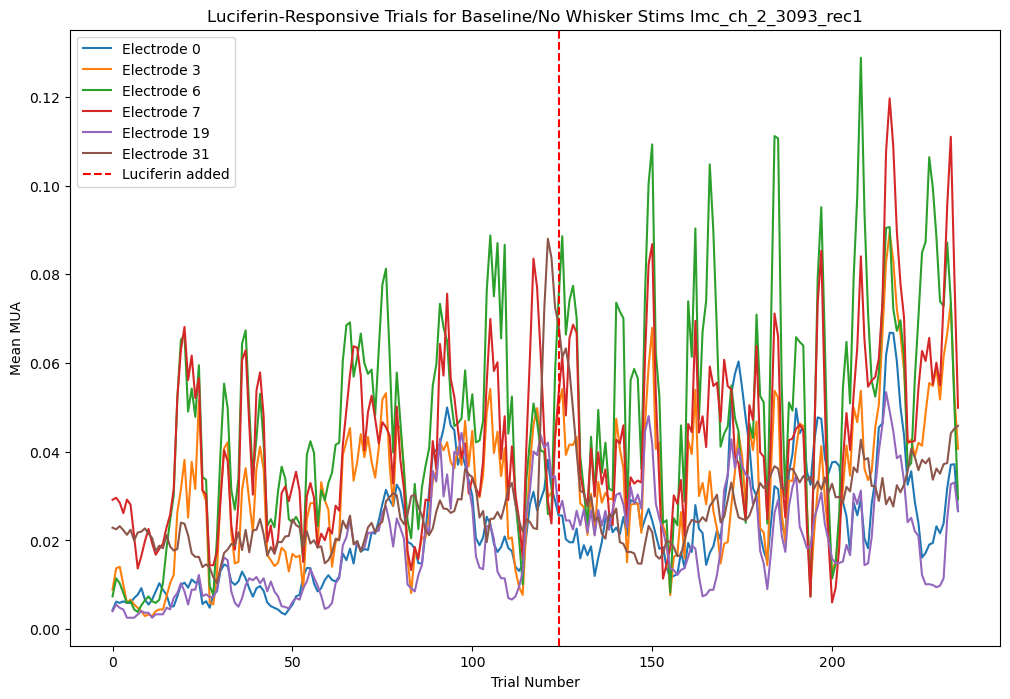

Estimating firing rates for lmc_ch_1_3094_rec2...


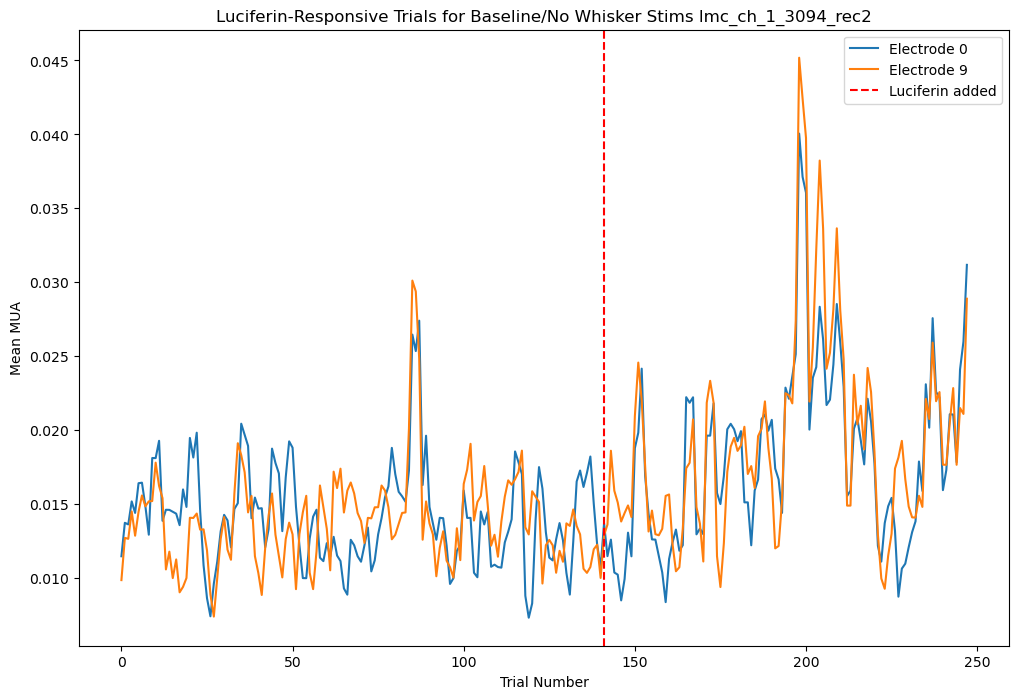

Estimating firing rates for lmc_ch_1_3094_rec1...


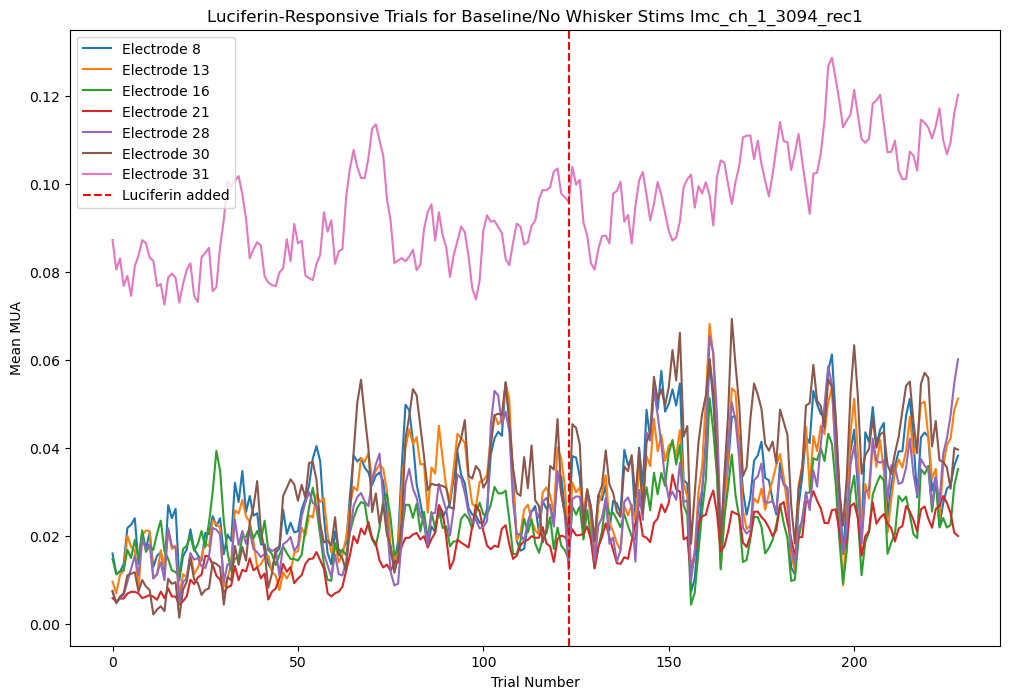

Estimating firing rates for lmc_noch_1_3096_rec1...


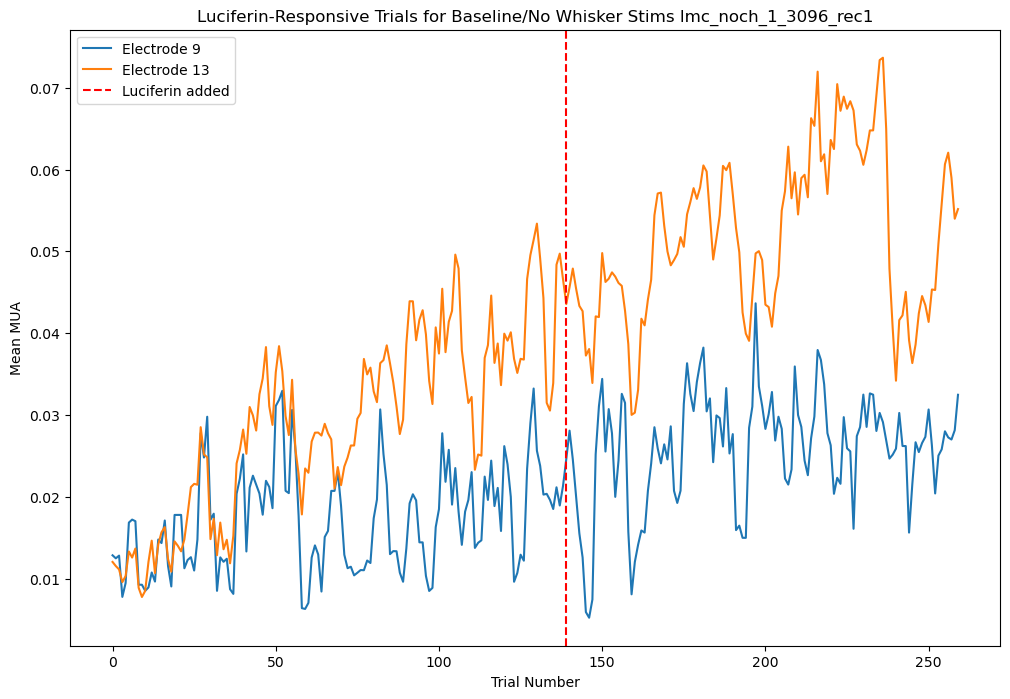

Estimating firing rates for lmc_noch_1_3096_rec2...


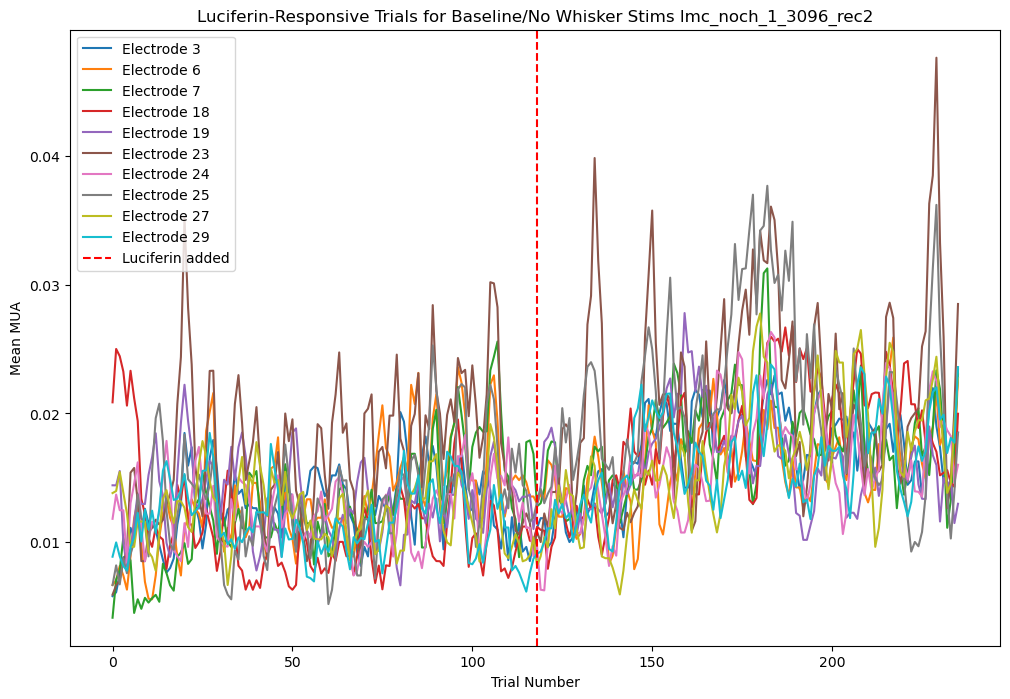

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_luciferin_responsive_trials(recording_results_df, stimulation_data_df, luciferin_responsive_electrodes_dict, n_channels, bin_size=0.001, smoothing_window=None, plot_percent_change=False):
    # Define the timestamps for when luciferin was added for each recording
    luciferin_timestamps = {
        'lmc_ch_1_3094_rec1': 4.076459533333333e+03,
        'lmc_ch_1_3094_rec2': 4.082218733333333e+03,
        'lmc_ch_2_3093_rec1': 4.076533433333334e+03,
        'lmc_noch_1_3096_rec1': 4.080881200000000e+03,
        'lmc_noch_1_3096_rec2': 4.088738733333333e+03,
    }
    
    # Iterate over unique recording names
    for recording_name in recording_results_df['recording_name'].unique():
        print(f"Estimating firing rates for {recording_name}...")
        
        # Replace this with the actual function call to estimate_instantaneous_firing_rate
        firing_rate_estimates = estimate_instantaneous_firing_rate(recording_name, recording_results_df, n_channels)
        
        # Get the luciferin-responsive electrodes for this recording
        responsive_electrodes = luciferin_responsive_electrodes_dict.get(recording_name, [])
        
        if not responsive_electrodes:
            print(f"No luciferin-responsive electrodes found for {recording_name}. Skipping.")
            continue

        # Fetch the time when luciferin was added for the current recording
        luciferin_time = luciferin_timestamps.get(recording_name, None)
        if luciferin_time is None:
            print(f"No luciferin timestamp found for {recording_name}. Skipping.")
            continue
        
        # Create a new figure for each recording
        plt.figure(figsize=(12, 8))

        # Plot only for luciferin-responsive electrodes
        for ch in responsive_electrodes:
            # Your logic to fetch the relevant trials where stim_id == 1, both pre and post luciferin
            # You will replace 'all_baseline_data' and 'all_luciferin_data' with the actual data
            all_baseline_data = []
            all_luciferin_data = []

            # Filter data for stimulations with ID == 1
            stim_data_all = stimulation_data_df[
                (stimulation_data_df['recording_name'] == recording_name) &
                (stimulation_data_df['stimulation_ids'] == 1)
            ]
            # Define 'n' as the number of trials you want to consider
            n = 100  # Or any other number 
            # Filter pre- and post-luciferin data
            # stim_data_pre = stim_data_all[stim_data_all['onset_times'] < luciferin_time].head(n)
            # stim_data_post = stim_data_all[stim_data_all['onset_times'] > luciferin_time].tail(n)
            
            # no filtering of data, just plotting all the data for all trials for a given stim ID == 1
            stim_data_pre = stim_data_all[stim_data_all['onset_times'] < luciferin_time]
            stim_data_post = stim_data_all[stim_data_all['onset_times'] > luciferin_time]
            
            
            # Collect data for baseline (pre-luciferin)
            for onset in stim_data_pre['onset_times']:
                start_bin = int(onset / bin_size)
                end_bin = int( (onset + 0.9) / bin_size)
                # print(f"Start bin for baseline: {start_bin}, End bin for baseline: {end_bin}")
                # baseline_data = np.mean(firing_rate_estimates[ch, start_bin:end_bin])
                # Instead of np.mean, use np.nanmean
                baseline_data = np.nanmean(firing_rate_estimates[ch, start_bin:end_bin])
                all_baseline_data.append(baseline_data)

            # Collect data for post-luciferin
            for onset in stim_data_post['onset_times']:
                start_bin = int(onset / bin_size)
                end_bin = int( (onset+0.9) / bin_size)
                # print(f"Start bin for post-luciferin: {start_bin}, End bin for post-luciferin: {end_bin}")
                # luciferin_data = np.mean(firing_rate_estimates[ch, start_bin:end_bin])
                # Instead of np.mean, use np.nanmean
                luciferin_data = np.nanmean(firing_rate_estimates[ch, start_bin:end_bin])
                all_luciferin_data.append(luciferin_data)
            
            # Concatenating pre-luciferin and post-luciferin data
            all_data = all_baseline_data + all_luciferin_data
            
            # Optionally smooth the data
            if smoothing_window is not None:
                all_data = np.convolve(all_data, np.ones(smoothing_window)/smoothing_window, mode='valid')
            
            plt.plot(all_data, label=f'Electrode {ch}')
        
        # Add a red dotted line to indicate when luciferin was added
        plt.axvline(x=len(all_baseline_data), color='r', linestyle='--', label='Luciferin added')
        
        plt.title(f'Luciferin-Responsive Trials for Baseline/No Whisker Stims {recording_name}')
        plt.xlabel('Trial Number')
        plt.ylabel('Mean MUA')
        plt.legend()
        plt.show()
        
        
# Call the function
plot_luciferin_responsive_trials(analysis.recording_results_df, analysis.stimulation_data_df, luciferin_responsive_electrodes_dict, analysis.n_channels, bin_size=0.001, smoothing_window=3)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_luciferin_responsive_trials(recording_results_df, stimulation_data_df, luciferin_responsive_electrodes_dict, n_channels, bin_size=0.001, smoothing_window=None, plot_percent_change=False):
    # Define the timestamps for when luciferin was added for each recording
    luciferin_timestamps = {
        'lmc_ch_1_3094_rec1': 4.076459533333333e+03,
        'lmc_ch_1_3094_rec2': 4.082218733333333e+03,
        'lmc_ch_2_3093_rec1': 4.076533433333334e+03,
        'lmc_noch_1_3096_rec1': 4.080881200000000e+03,
        'lmc_noch_1_3096_rec2': 4.088738733333333e+03,
    }
    
    # Iterate over unique recording names
    for recording_name in recording_results_df['recording_name'].unique():
        print(f"Estimating firing rates for {recording_name}...")
        
        # Replace this with the actual function call to estimate_instantaneous_firing_rate
        firing_rate_estimates = estimate_instantaneous_firing_rate(recording_name, recording_results_df, n_channels)
        
        # Get the luciferin-responsive electrodes for this recording
        responsive_electrodes = luciferin_responsive_electrodes_dict.get(recording_name, [])
        
        if not responsive_electrodes:
            print(f"No luciferin-responsive electrodes found for {recording_name}. Skipping.")
            continue

        # Fetch the time when luciferin was added for the current recording
        luciferin_time = luciferin_timestamps.get(recording_name, None)
        if luciferin_time is None:
            print(f"No luciferin timestamp found for {recording_name}. Skipping.")
            continue
        
        # Create a new figure for each recording
        plt.figure(figsize=(12, 8))

        # Plot only for luciferin-responsive electrodes
        for ch in responsive_electrodes:
            # Initialize lists to hold moving average data
            moving_avg_pre = []
            moving_avg_post = []
            
            # Filter data for stimulations with ID == 1
            stim_data_all = stimulation_data_df[
                (stimulation_data_df['recording_name'] == recording_name) &
                (stimulation_data_df['stimulation_ids'] == 1)
            ]
            
            # no filtering of data, just plotting all the data for all trials for a given stim ID == 1
            stim_data_pre = stim_data_all[stim_data_all['onset_times'] < luciferin_time]
            stim_data_post = stim_data_all[stim_data_all['onset_times'] > luciferin_time]
            
            # Calculate 60s moving average for pre-luciferin data
            for onset in stim_data_pre['onset_times']:
                start_bin = int(onset / bin_size)
                end_bin = int((onset + 0.9) / bin_size)
                baseline_data = np.nanmean(firing_rate_estimates[ch, start_bin:end_bin])
                moving_avg_pre.append(baseline_data)
            
            # Calculate 60s moving average for post-luciferin data
            for onset in stim_data_post['onset_times']:
                start_bin = int(onset / bin_size)
                end_bin = int((onset + 0.9) / bin_size)
                luciferin_data = np.nanmean(firing_rate_estimates[ch, start_bin:end_bin])
                moving_avg_post.append(luciferin_data)
            
            # If plot_percent_change is True, convert post-luciferin data to percent change
            if plot_percent_change:
                baseline_mean = np.mean(moving_avg_pre)
                moving_avg_post = [(x - baseline_mean) / baseline_mean * 100 for x in moving_avg_post]
                ylabel_text = 'Percent Change from Baseline'
            else:
                ylabel_text = 'Mean MUA'
            
            # Concatenate to form one long array
            all_data = moving_avg_pre + moving_avg_post
            
            # Optionally smooth the data
            if smoothing_window is not None:
                all_data = np.convolve(all_data, np.ones(smoothing_window)/smoothing_window, mode='valid')
            
            plt.plot(all_data, label=f'Electrode {ch}')
        
        # Add a red dotted line to indicate when luciferin was added
        plt.axvline(x=len(moving_avg_pre), color='r', linestyle='--', label='Luciferin added')
        
        plt.title(f'Luciferin-Responsive Trials for {recording_name}')
        plt.xlabel('Trial Number')
        plt.ylabel(ylabel_text)
        plt.legend()
        plt.show()

# Call the function
plot_luciferin_responsive_trials(analysis.recording_results_df, analysis.stimulation_data_df, luciferin_responsive_electrodes_dict, analysis.n_channels, bin_size=0.001, smoothing_window= None, plot_percent_change=True)